In [74]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In this notebook, I am explorign the relationship between how much the hospital/providers charges per service, and how much each hospital is actually getting paid for service performed. 

In [95]:
hrr_gdf = pd.read_pickle('Dataframes/merged_hrr_gdf')
provider_gdf = pd.read_pickle('Dataframes/gdf_medicare_correct_hrr')

In [96]:
provider_gdf.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,long_lat,geometry,city_state,HRRD
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73,"(-85.3928604125977, 31.2167854309082)",POINT (-85.3928604125977 31.2167854309082),"DOTHAN, AL",ALDOTHAN
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14.0,15131.85,5787.57,4976.71,"(-86.3727798461914, 34.1399955749512)",POINT (-86.37277984619141 34.1399955749512),"BOAZ, AL",ALBIRMINGHAM
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24.0,37560.37,5434.95,4453.79,"(-87.6751022338867, 34.8017730712891)",POINT (-87.6751022338867 34.8017730712891),"FLORENCE, AL",ALBIRMINGHAM
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25.0,13998.28,5417.56,4129.16,"(-86.636100769043, 33.6505241394043)",POINT (-86.636100769043 33.6505241394043),"BIRMINGHAM, AL",ALBIRMINGHAM
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18.0,31633.27,5658.33,4851.44,"(-86.8290939331055, 33.2154388427734)",POINT (-86.8290939331055 33.2154388427734),"ALABASTER, AL",ALBIRMINGHAM


In [8]:
provider_gdf['DRG Definition'].nunique()

100

There are 100 types of procedures categorized here. 

In [97]:
#presetting plot related parameters 
plt.rcParams['figure.figsize'] = (18,10)
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12)    
plt.rc('axes', labelsize= 15) 

Text(0.5,0.04,'Dollar Amount')

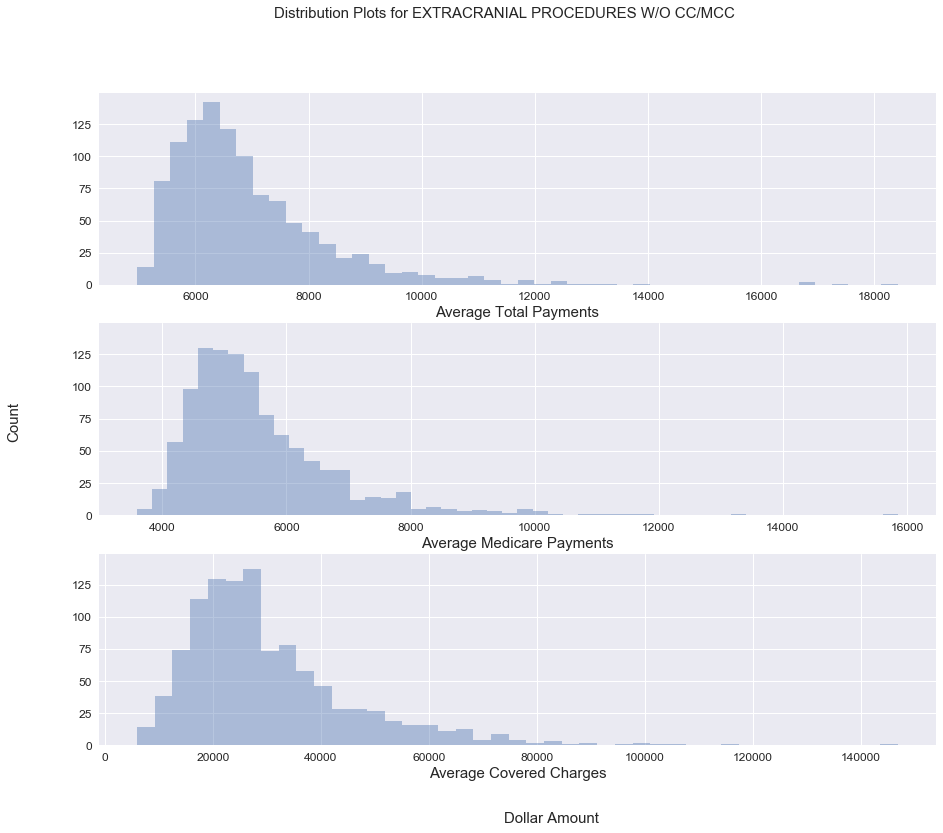

In [98]:
fig1, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, figsize = (15,12)) 
drg_039 = provider_gdf.loc[provider_gdf['DRG Definition'] ==
                 '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC']
sns.distplot(drg_039['Average Total Payments'], kde=False, ax = ax1)
sns.distplot(drg_039['Average Medicare Payments'], kde=False,ax = ax2)
sns.distplot(drg_039['Average Covered Charges'], kde=False, ax = ax3)
fig1.suptitle('Distribution Plots for EXTRACRANIAL PROCEDURES W/O CC/MCC', fontsize=15)
fig1.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize = 15)
fig1.text(0.5, 0.04, 'Dollar Amount', va='center', fontsize = 15)

In the graph above, I took one type of procedure(EXTRACRANIAL PROCEDURES W/O CC/MCC) and plotted out the distribution of the plots. The graphs shows the charges far exceed to medicare and total payments. There are some far extremes, where providers charged for over 150,000. 

In [24]:
#Back to using the entire dataset
provider_gdf['charge_tpay_diff'] =  (provider_gdf['Average Covered Charges']-
                                     provider_gdf['Average Total Payments'])

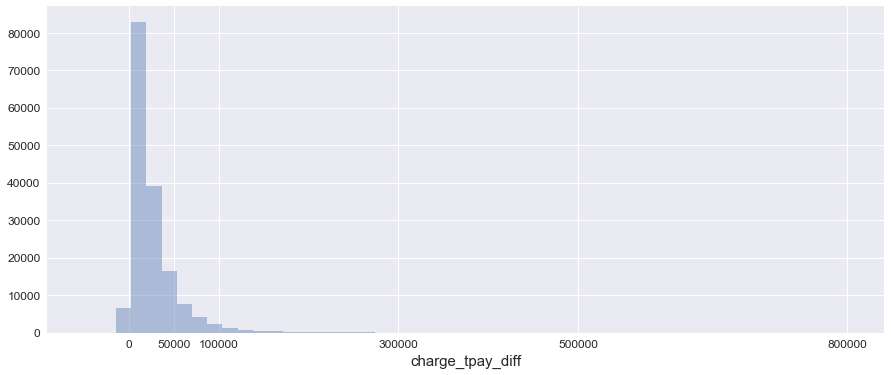

In [89]:
fig2, ax4 = plt.subplots(figsize = (15,6))
ax4.set_xticks([0, 50000, 100000, 300000, 500000,
                     800000])
sns.distplot(provider_gdf['charge_tpay_diff'], kde=False, ax = ax4)


Here I took the difference between total payment and charges, most of the difference in payment is clustered around 10,000 to 20,00 dollars. 

In [90]:
X = provider_gdf['Average Covered Charges']
y = provider_gdf['Average Medicare Payments']
smresults = sm.OLS(y, X,).fit()
print(smresults.summary())

                                OLS Regression Results                               
Dep. Variable:     Average Medicare Payments   R-squared:                       0.798
Model:                                   OLS   Adj. R-squared:                  0.798
Method:                        Least Squares   F-statistic:                 6.438e+05
Date:                       Sun, 18 Mar 2018   Prob (F-statistic):               0.00
Time:                               21:20:53   Log-Likelihood:            -1.6215e+06
No. Observations:                     163065   AIC:                         3.243e+06
Df Residuals:                         163064   BIC:                         3.243e+06
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

Here I fitted a linear regression between the medicare payment and charges to see if there is an apporximate linear relationship. The coefficent value shows that medicare will pay approxmately 20 cents on the dollar, the R2 value is 0.78, so there appears to be somewhat of a linear relationship for the entire dataset. 

In [99]:
#Ratio between charges and medicare payment
provider_gdf['medi_ratio'] = (provider_gdf['Average Covered Charges']/
                              provider_gdf['Average Medicare Payments'])

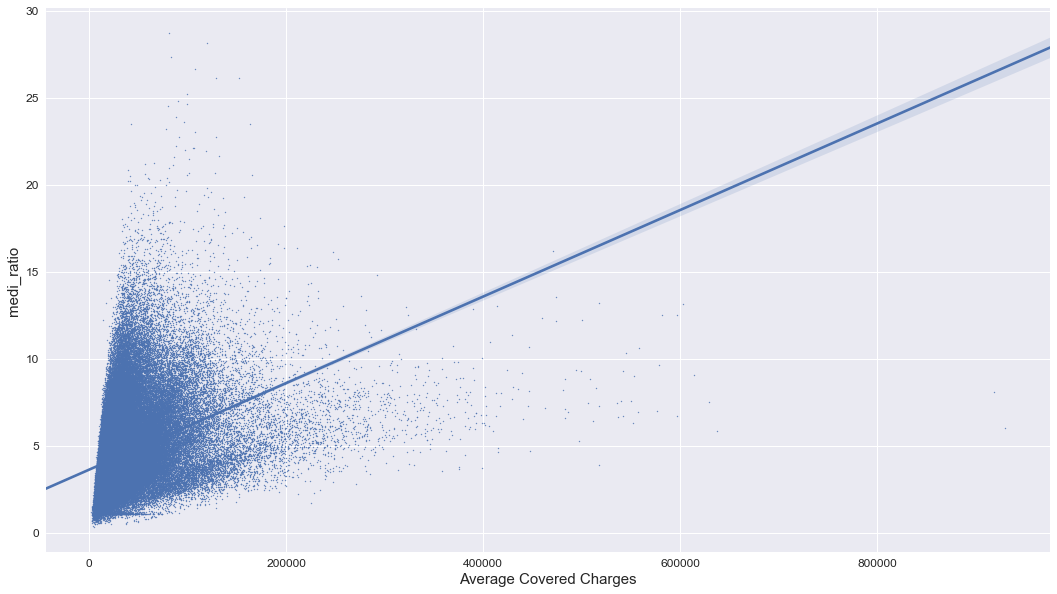

In [100]:
sns.regplot(x = provider_gdf['Average Covered Charges'],
           y = provider_gdf['medi_ratio'], scatter_kws={"s": 2})

Here is a visual representation of charges againist the ratio of charges vs medicare payment. 